# **Klasifikasi Buah Matang dan Mentah Menggunakan Pemrosesan Citra Warna dan Ekstraksi Ciri Warna** #

# **Import Library**

In [17]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import glob
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# **Deskripsi Data**

Dataset yang digunakan dalam proyek ini terdiri dari gambar buah-buahan yang dikategorikan berdasarkan tingkat kematangannya: segar (fresh) atau busuk (rotten). Data ini mencakup tiga jenis buah—pisang (banana), apel (apple), dan jeruk (orange). Setiap kategori berisi gambar dengan format JPG atau PNG.

- Jenis data: Data citra (format RGB), yang kemudian dikonversi ke HSV untuk ekstraksi fitur berbasis warna.

- Sumber data: https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification
- Jumlah data: 13599 gambar

In [18]:
from tabulate import tabulate
import os
import glob
import itertools

# Fungsi bantu
def get_all_image_paths(directory):
    extensions = ['*.png']
    image_paths = list(itertools.chain.from_iterable(
        glob.glob(os.path.join(directory, ext)) for ext in extensions
    ))
    return image_paths

# Fungsi menampilkan tabel dan mengembalikan total data
def count_dataset_table(train_dir, test_dir, categories):
    table = []
    total_train = 0
    total_test = 0

    for category in categories:
        train_paths = get_all_image_paths(os.path.join(train_dir, category))
        test_paths = get_all_image_paths(os.path.join(test_dir, category))
        total = len(train_paths) + len(test_paths)

        table.append([category, len(train_paths), len(test_paths), total])
        total_train += len(train_paths)
        total_test += len(test_paths)

    table.append(['TOTAL', total_train, total_test, total_train + total_test])
    
    headers = ['Kategori', 'Train', 'Test', 'Total']
    print(tabulate(table, headers=headers, tablefmt='grid'))

    return total_train + total_test  # return total per buah

# MAIN
base_dir = r"datasets"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
fruit_types = ['apples', 'banana', 'oranges']

# Variabel untuk menyimpan total semua data
grand_total = 0

# Proses per buah
for fruit in fruit_types:
    print(f"\n== {fruit.upper()} ==")
    categories = [f"fresh{fruit}", f"rotten{fruit}"]
    total_per_fruit = count_dataset_table(train_dir, test_dir, categories)
    grand_total += total_per_fruit

# Cetak total akhir
print(f"\nTotal keseluruhan data dari semua kategori: {grand_total} gambar")



== APPLES ==
+--------------+---------+--------+---------+
| Kategori     |   Train |   Test |   Total |
+==============+=========+========+=========+
| freshapples  |    1693 |    395 |    2088 |
+--------------+---------+--------+---------+
| rottenapples |    2342 |    601 |    2943 |
+--------------+---------+--------+---------+
| TOTAL        |    4035 |    996 |    5031 |
+--------------+---------+--------+---------+

== BANANA ==
+--------------+---------+--------+---------+
| Kategori     |   Train |   Test |   Total |
+==============+=========+========+=========+
| freshbanana  |    1581 |    381 |    1962 |
+--------------+---------+--------+---------+
| rottenbanana |    2224 |    530 |    2754 |
+--------------+---------+--------+---------+
| TOTAL        |    3805 |    911 |    4716 |
+--------------+---------+--------+---------+

== ORANGES ==
+---------------+---------+--------+---------+
| Kategori      |   Train |   Test |   Total |
+===============+=========+========

# **EDA**

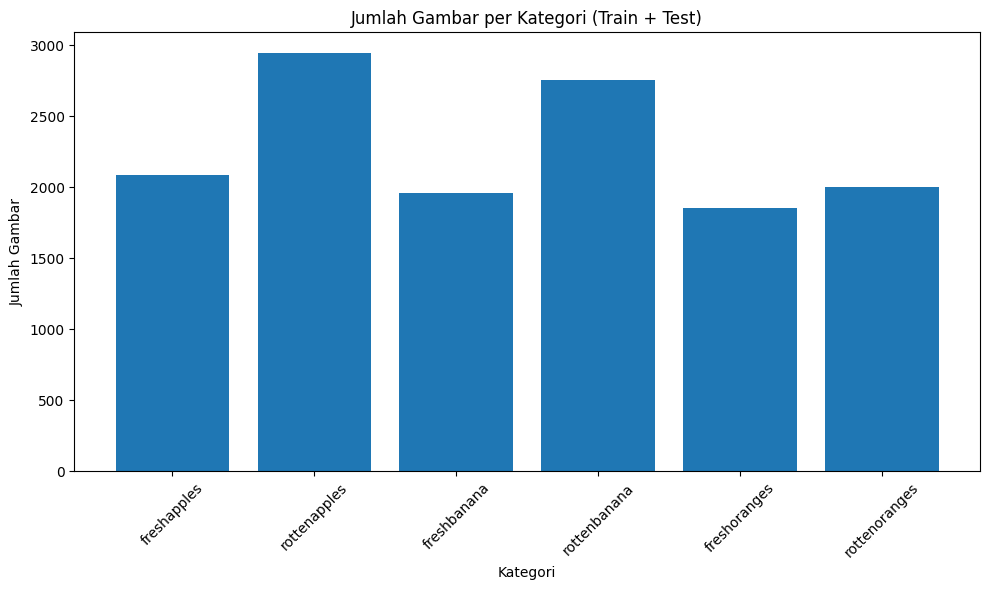

In [19]:
def count_data_for_plot(train_dir, test_dir, categories):
    labels = []
    counts = []
    for category in categories:
        train_paths = get_all_image_paths(os.path.join(train_dir, category))
        test_paths = get_all_image_paths(os.path.join(test_dir, category))
        total = len(train_paths) + len(test_paths)
        labels.append(category)
        counts.append(total)
    return labels, counts

# ==== Set Path dan Kategori ====
base_dir = r"datasets"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

fruit_types = ['apples', 'banana', 'oranges']
all_categories = []
for fruit in fruit_types:
    all_categories.extend([f"fresh{fruit}", f"rotten{fruit}"])

# ==== Hitung dan Plot ====
labels, counts = count_data_for_plot(train_dir, test_dir, all_categories)

plt.figure(figsize=(10, 6))
plt.bar(labels, counts)
plt.title("Jumlah Gambar per Kategori (Train + Test)")
plt.xlabel("Kategori")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# **Alur Program Klasifikasi Tingkat Kematangan Buah**
Mengandalkan ekstraksi warna (hue) sebagai fitur pembeda tingkat kematangan buah secara efektif.

1. Inisialisasi (__init__)
    -  Menyimpan direktori data latih (train_dir) dan data uji (test_dir).
    - Menyiapkan struktur data untuk kategori buah dan rentang hue masing-masing.

2. Konversi Warna (rgb_to_hsv)
    - Mengubah gambar dari format RGB ke HSV secara manual.
    - Fokus pada nilai Hue (H) sebagai fitur utama untuk mengukur tingkat kematangan buah berdasarkan warna.

3. Pra-pemrosesan Gambar (preprocess_image) Membaca dan membersihkan gambar dengan:
    - Median blur (mengurangi noise)
    - CLAHE (meningkatkan kontras)
    Menghasilkan gambar RGB yang lebih jelas untuk analisis warna.

4. Ekstraksi Fitur (extract_features)
    - Mengekstrak nilai statistik dari channel hue: Rata-rata (mean), Median, Standar deviasi (std)
    - Fokus pada bagian gambar dengan saturasi dan kecerahan tinggi (area dominan buah).

5. Pelatihan Model (train)
    - Hitung rata-rata dan deviasi hue dari gambar latih.
    - Simpan rentang hue representatif (mean ± 2×std) sebagai referensi klasifikasi.

6. Klasifikasi Gambar Uji (classify_image)
    - Ekstraksi fitur dari gambar uji.
    - Bandingkan hue dominan terhadap rentang hue kategori latih.

    Hitung skor kemiripan berdasarkan:
    - Jarak hue (hue_distance)
    - Penalti jika distribusi hue tidak wajar (std_penalty)
    - Penalti jika hue dominan di luar rentang kategori (hue_penalty)

    Pilih kategori dengan total skor terkecil.

7. Evaluasi Model (evaluate)
    - Bandingkan prediksi terhadap label asli dari gambar uji.

8. Visualisasi Hasil

9. Mengembalikan nilai akurasi akhir dari model.

# **Definisi Kelas FruitRipenessClassifier**



In [20]:
class FruitRipenessClassifier:
    # Menyimpan direktori training dan testing, serta menginisialisasi struktur data kategori dan rentang hue.
    def __init__(self, train_dir, test_dir):
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.categories = []
        self.hue_ranges = {}

    # Mengonversi gambar RGB ke HSV secara manual.
    # H: warna (hue) → digunakan sebagai fitur utama dalam klasifikasi
    # S: seberapa murni warna (saturation)
    # V: seberapa terang warna (value)
    def rgb_to_hsv(self, rgb_img):  
        # Normalisasi nilai RGB ke rentang [0, 1]
        rgb_norm = rgb_img.astype(np.float32) / 255.0
        r, g, b = rgb_norm[:, :, 0], rgb_norm[:, :, 1], rgb_norm[:, :, 2]

        # Value (V) adalah nilai maksimum dari R, G, B
        v = np.max(rgb_norm, axis=2)

        # Delta adalah selisih antara maksimum dan minimum dari R, G, B
        min_rgb = np.min(rgb_norm, axis=2)
        delta = v - min_rgb

        # Inisialisasi Saturation (S) dengan nol
        s = np.zeros_like(v)
        non_zero_v_mask = v != 0
        s[non_zero_v_mask] = delta[non_zero_v_mask] / v[non_zero_v_mask]
        # Jika nilai V = 0 (hitam), maka S = 0

        # Inisialisasi Hue (H) dengan nol
        h = np.zeros_like(v)
        non_zero_delta_mask = delta != 0

        # Mask untuk menentukan warna dominan
        red_max_mask = (v == r) & non_zero_delta_mask
        green_max_mask = (v == g) & non_zero_delta_mask
        blue_max_mask = (v == b) & non_zero_delta_mask

        # Hitung Hue berdasarkan channel yang dominan
        h[red_max_mask] = ((g[red_max_mask] - b[red_max_mask]) / delta[red_max_mask]) % 6
        h[green_max_mask] = 2 + (b[green_max_mask] - r[green_max_mask]) / delta[green_max_mask]
        h[blue_max_mask] = 4 + (r[blue_max_mask] - g[blue_max_mask]) / delta[blue_max_mask]

        # Konversi H dari satuan derajat ke rentang [0, 1]
        h = h * 60         # Dari satuan 0–6 menjadi 0–360 derajat
        h[h < 0] += 360    # Jika hasil negatif, tambahkan 360 agar tetap dalam rentang
        h = h / 360.0      # Skala ke rentang [0, 1]

        # Gabungkan H, S, dan V ke dalam satu array
        return np.stack([h, s, v], axis=2)

    # Fungsi untuk preprocessing gambar agar lebih bersih dan kontras
    # Digunakan untuk memperbaiki kualitas input sebelum ekstraksi fitur
    def preprocess_image(self, image_path):
        img = cv2.imread(image_path)
        if img is None:
            print(f"[WARNING] Could not read image: {image_path}")
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.medianBlur(img, 5)
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
        img_eq = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
        return img_eq

    # Fungsi untuk ekstraksi fitur dari gambar HSV
    # Menghasilkan nilai statistik dari channel hue
    def extract_features(self, preprocessed_img):
        hsv_img = self.rgb_to_hsv(preprocessed_img)
        hue_channel = hsv_img[:, :, 0]
        s_channel = hsv_img[:, :, 1]
        v_channel = hsv_img[:, :, 2]
        mask = (s_channel > 0.3) & (v_channel > 0.3)
        masked_hue = hue_channel[mask]
        if len(masked_hue) == 0:
            masked_hue = hue_channel.flatten()

        return {
            'hue_mean': np.mean(hue_channel),
            'hue_std': np.std(hue_channel),
            'hue_median': np.median(hue_channel),
            'significant_hue_mean': np.mean(masked_hue),
            'significant_hue_std': np.std(masked_hue),
            'hsv_img': hsv_img
        }
        
    # Fungsi pelatihan classifier berdasarkan hue dari gambar latih
    # Hasilnya berupa rentang hue representatif tiap kategori
    def train(self):
        print("Training the classifier...")
        for category in self.categories:
            print(f"Processing category: {category}")
            category_features = []
            image_paths = get_all_image_paths(os.path.join(self.train_dir, category))
            for img_path in image_paths:
                preprocessed_img = self.preprocess_image(img_path)
                if preprocessed_img is not None:
                    features = self.extract_features(preprocessed_img)
                    category_features.append(features)
            if len(category_features) > 0:
                hue_means = [f['significant_hue_mean'] for f in category_features]
                hue_stds = [f['significant_hue_std'] for f in category_features]
                avg_hue_mean = np.mean(hue_means)
                avg_hue_std = np.mean(hue_stds)
                self.hue_ranges[category] = {
                    'min': max(0, avg_hue_mean - 2 * avg_hue_std),
                    'max': min(1, avg_hue_mean + 2 * avg_hue_std),
                    'mean': avg_hue_mean,
                    'std': avg_hue_std
                }
                print(f"  {category} - Hue range: {self.hue_ranges[category]['min']:.3f} to {self.hue_ranges[category]['max']:.3f}")
            else:
                print(f"[WARNING] No training data for category: {category}")
        print("Training completed.")
        
    # Fungsi untuk mengklasifikasikan satu gambar menggunakan jarak hue ke data latih
    # Memilih kategori dengan skor total terendah (paling mirip)
    def classify_image(self, image_path):
        preprocessed_img = self.preprocess_image(image_path)
        if preprocessed_img is None:
            return None, None
        features = self.extract_features(preprocessed_img)

        best_match = None
        min_distance = float('inf')
        for category, hue_range in self.hue_ranges.items():
            hue_mean = features['significant_hue_mean']
            hue_std = features['significant_hue_std']
            hue_data = features['hsv_img'][:, :, 0]
            s_channel = features['hsv_img'][:, :, 1]
            v_channel = features['hsv_img'][:, :, 2]
            mask = (s_channel > 0.3) & (v_channel > 0.3)
            masked_hue = hue_data[mask]

            hist, bins = np.histogram(masked_hue, bins=50, range=(0, 1))
            most_freq_hue_bin_idx = np.argmax(hist)
            bin_center = (bins[most_freq_hue_bin_idx] + bins[most_freq_hue_bin_idx + 1]) / 2

            hue_distance = abs(hue_mean - hue_range['mean'])
            std_threshold = 0.05
            std_penalty = 0.1 if (('rotten' in category and hue_std < std_threshold) or
                                  ('fresh' in category and hue_std > std_threshold)) else 0.0
            hue_penalty = 0.1 if not (hue_range['min'] <= bin_center <= hue_range['max']) else 0.0
            total_score = hue_distance + std_penalty + hue_penalty

            if total_score < min_distance:
                min_distance = total_score
                best_match = category

        return best_match, features

    # Fungsi untuk mengevaluasi akurasi classifier terhadap dataset uji
    # Mengembalikan nilai akurasi dan confusion matrix
    def evaluate(self):
        print("Evaluating the classifier...")
        true_labels = []
        pred_labels = []
        for category in self.categories:
            print(f"Testing category: {category}")
            image_paths = get_all_image_paths(os.path.join(self.test_dir, category))
            for img_path in image_paths:
                predicted_class, _ = self.classify_image(img_path)
                if predicted_class is not None:
                    true_labels.append(category)
                    pred_labels.append(predicted_class)
        if len(true_labels) == 0:
            print("[ERROR] Tidak ada data uji yang valid.")
            return 0.0, np.zeros((len(self.categories), len(self.categories)))
        accuracy = accuracy_score(true_labels, pred_labels)
        print(f"Overall Accuracy: {accuracy:.4f}")
        cm = confusion_matrix(true_labels, pred_labels, labels=self.categories)
        return accuracy, cm

    # Fungsi visualisasi hasil prediksi dengan contoh gambar
    # Menampilkan RGB asli, channel Hue, dan HSV image
    def visualize_results(self, num_samples=2, fruit_name="fruit"):
        fig = plt.figure(figsize=(15, 20))
        fig.suptitle(f'Fruit Ripeness Classification Results - {fruit_name.capitalize()}', fontsize=16)
        sample_idx = 1
        for category in self.categories:
            image_paths = get_all_image_paths(os.path.join(self.test_dir, category))[:num_samples]
            for img_path in image_paths:
                preprocessed_img = self.preprocess_image(img_path)
                if preprocessed_img is None:
                    continue
                predicted_class, features = self.classify_image(img_path)
                if predicted_class and features:
                    ax1 = fig.add_subplot(len(self.categories), num_samples * 3, sample_idx)
                    ax1.imshow(preprocessed_img)
                    ax1.set_title(f"Original\nTrue: {category}")
                    ax1.axis('off')
                    ax2 = fig.add_subplot(len(self.categories), num_samples * 3, sample_idx + 1)
                    ax2.imshow(features['hsv_img'][:, :, 0], cmap='hsv')
                    ax2.set_title(f"Hue\nPred: {predicted_class}")
                    ax2.axis('off')
                    ax3 = fig.add_subplot(len(self.categories), num_samples * 3, sample_idx + 2)
                    ax3.imshow(hsv_to_rgb(features['hsv_img']))
                    ax3.set_title(f"HSV\nH_mean: {features['significant_hue_mean']:.3f}")
                    ax3.axis('off')
                    sample_idx += 3
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.savefig(f'classification_results_{fruit_name}.png', dpi=300)
        plt.show()

    # Fungsi untuk menampilkan confusion matrix hasil prediksi
    def visualize_confusion_matrix(self, cm, fruit_name="fruit"):
        if np.sum(cm) == 0:
            print(f"[SKIPPED] Confusion matrix kosong untuk {fruit_name}")
            return
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=self.categories, yticklabels=self.categories)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix - {fruit_name.capitalize()}')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{fruit_name}.png', dpi=300)
        plt.show()

    # Fungsi utama yang menjalankan seluruh pipeline: train → evaluate → visualisasi
    def run(self, fruit_name="fruit"):
        self.train()
        accuracy, cm = self.evaluate()
        if np.sum(cm) > 0:
            self.visualize_results(fruit_name=fruit_name)
            self.visualize_confusion_matrix(cm, fruit_name=fruit_name)
        return accuracy



==== Processing APPLES ====

Training the classifier...
Processing category: freshapples
  freshapples - Hue range: 0.000 to 0.629
Processing category: rottenapples
  rottenapples - Hue range: 0.000 to 0.272
Training completed.
Evaluating the classifier...
Testing category: freshapples
Testing category: rottenapples
Overall Accuracy: 0.8233


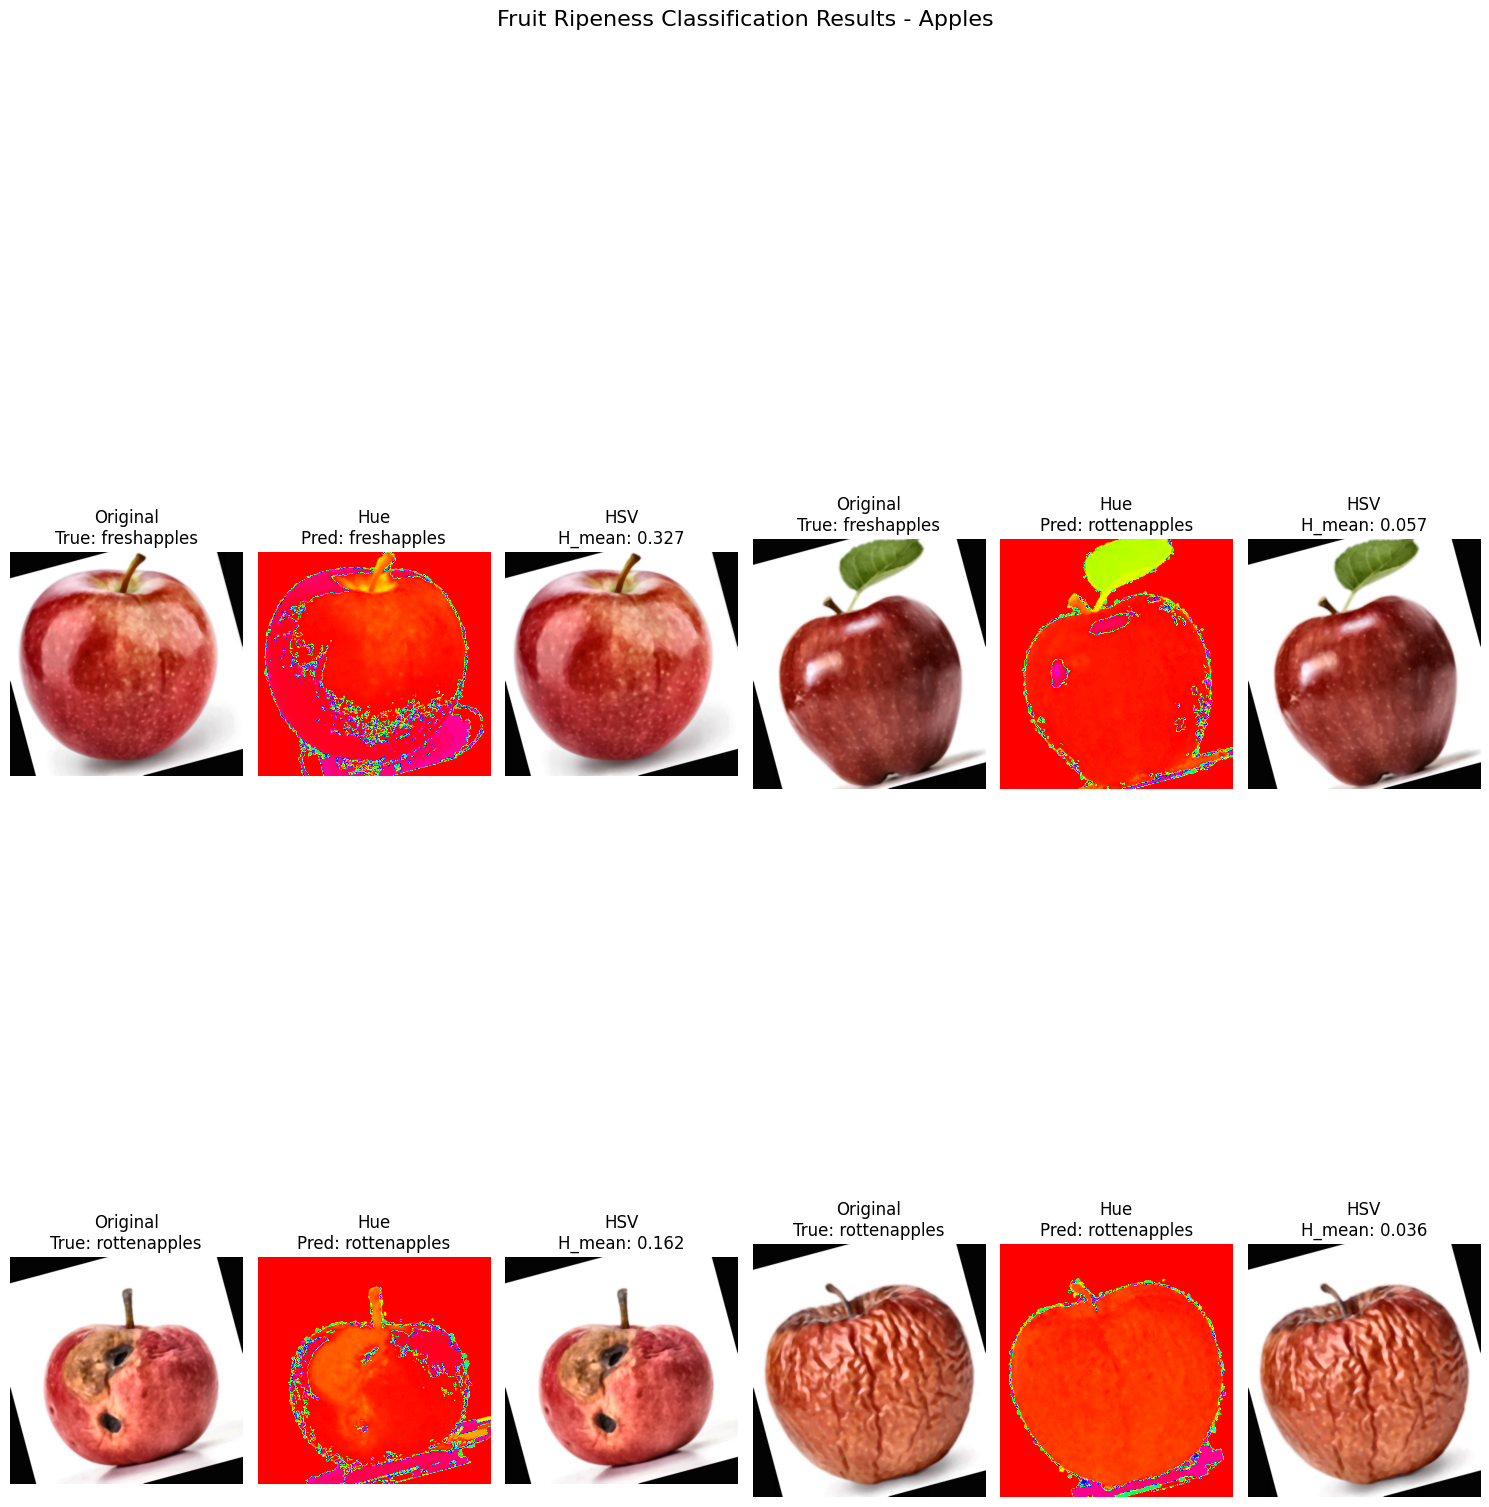

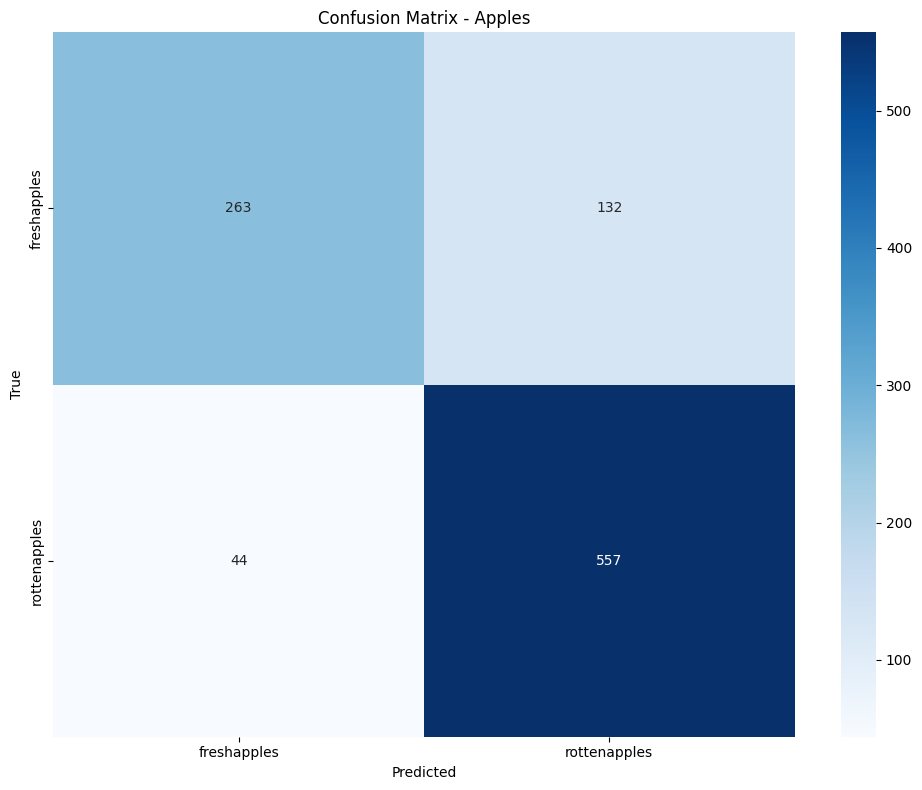

Apples classification accuracy: 0.8233

==== Processing BANANA ====

Training the classifier...
Processing category: freshbanana
  freshbanana - Hue range: 0.094 to 0.180
Processing category: rottenbanana
  rottenbanana - Hue range: 0.000 to 0.249
Training completed.
Evaluating the classifier...
Testing category: freshbanana
Testing category: rottenbanana
Overall Accuracy: 0.8496


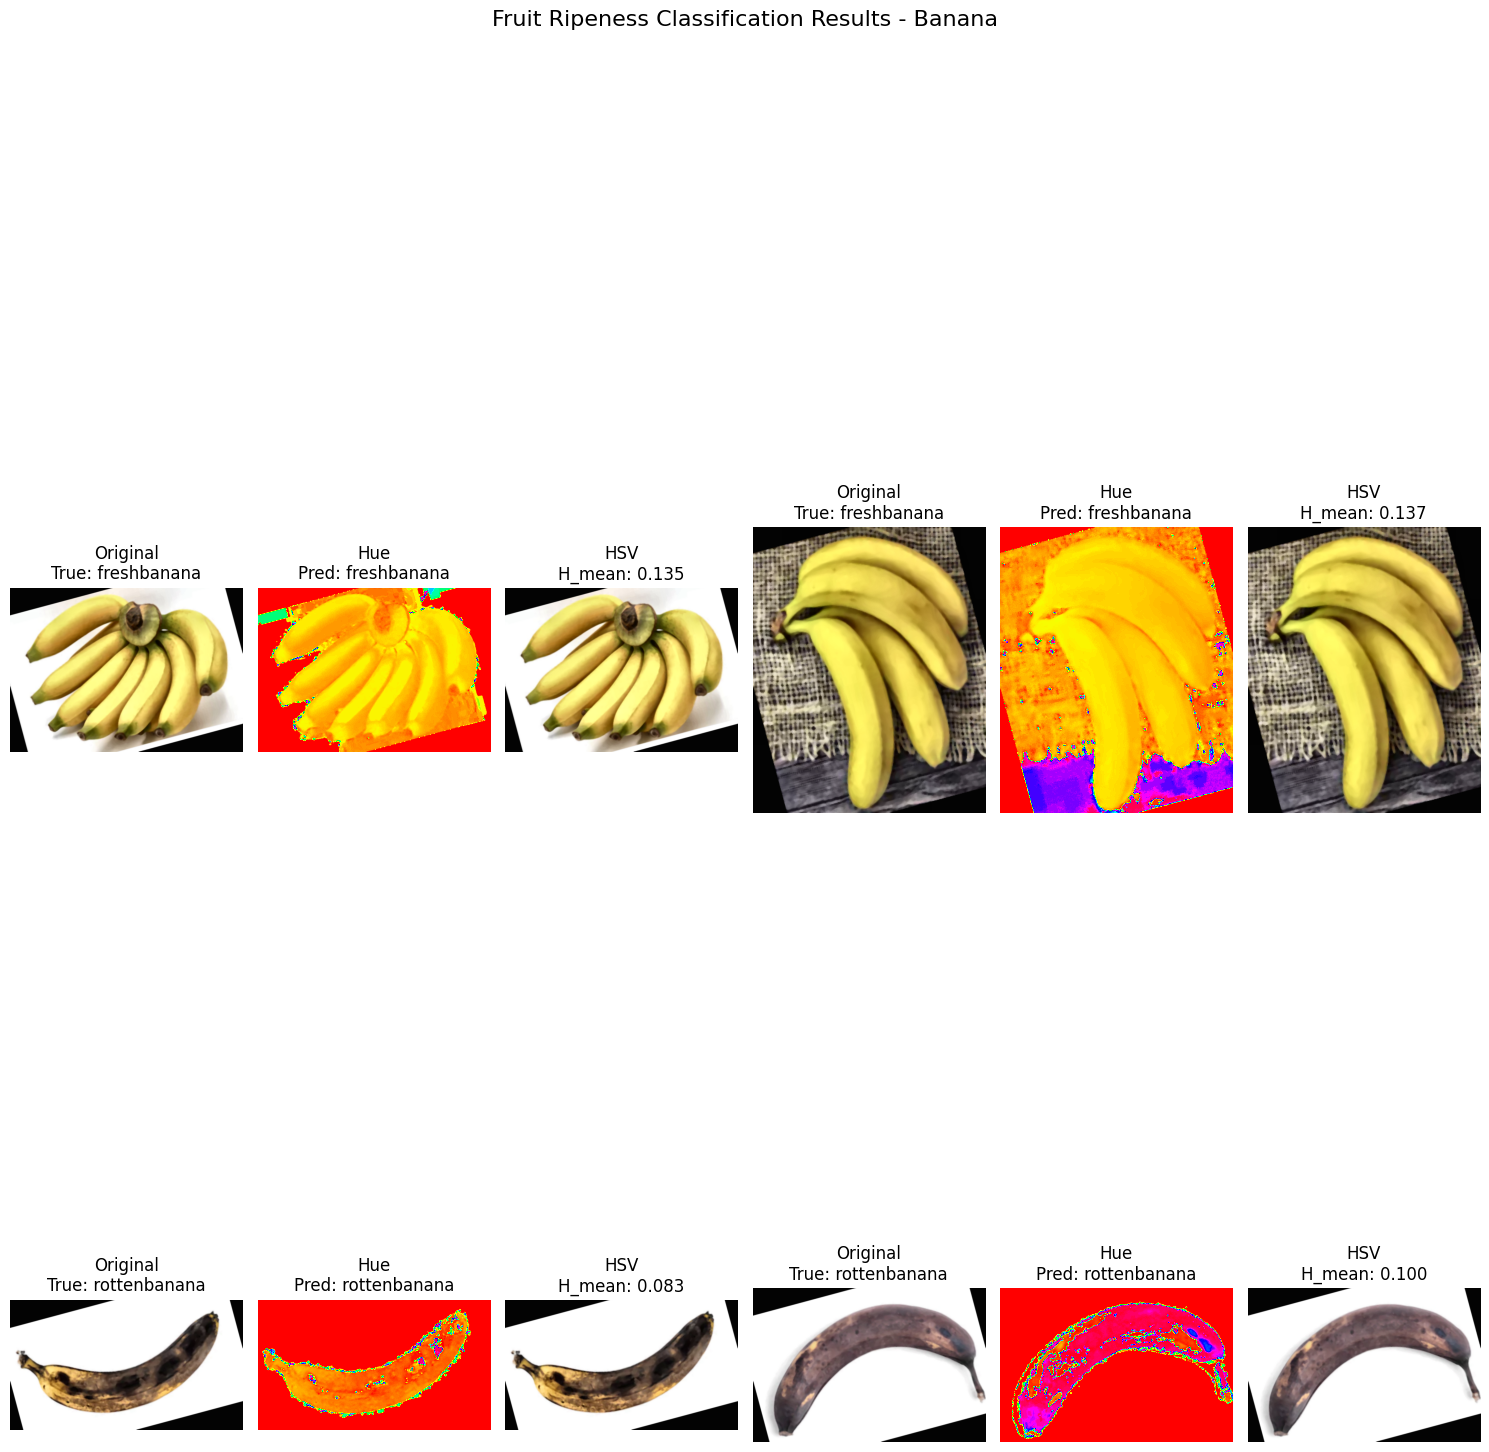

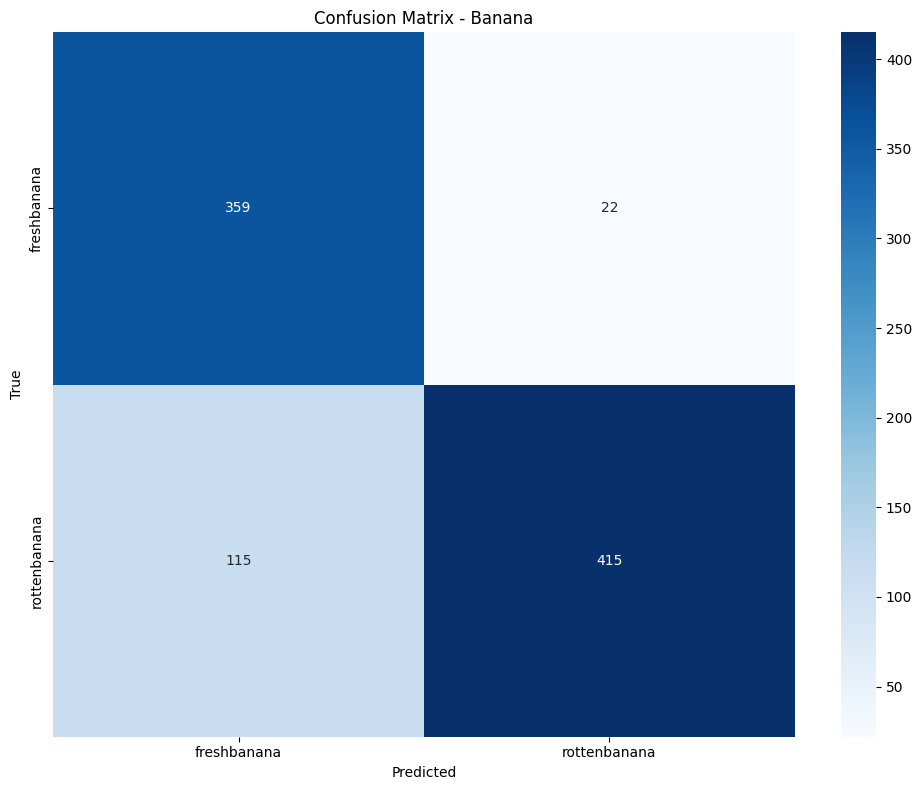

Banana classification accuracy: 0.8496

==== Processing ORANGES ====

Training the classifier...
Processing category: freshoranges
  freshoranges - Hue range: 0.011 to 0.169
Processing category: rottenoranges
  rottenoranges - Hue range: 0.000 to 0.176
Training completed.
Evaluating the classifier...
Testing category: freshoranges
Testing category: rottenoranges
Overall Accuracy: 0.4501


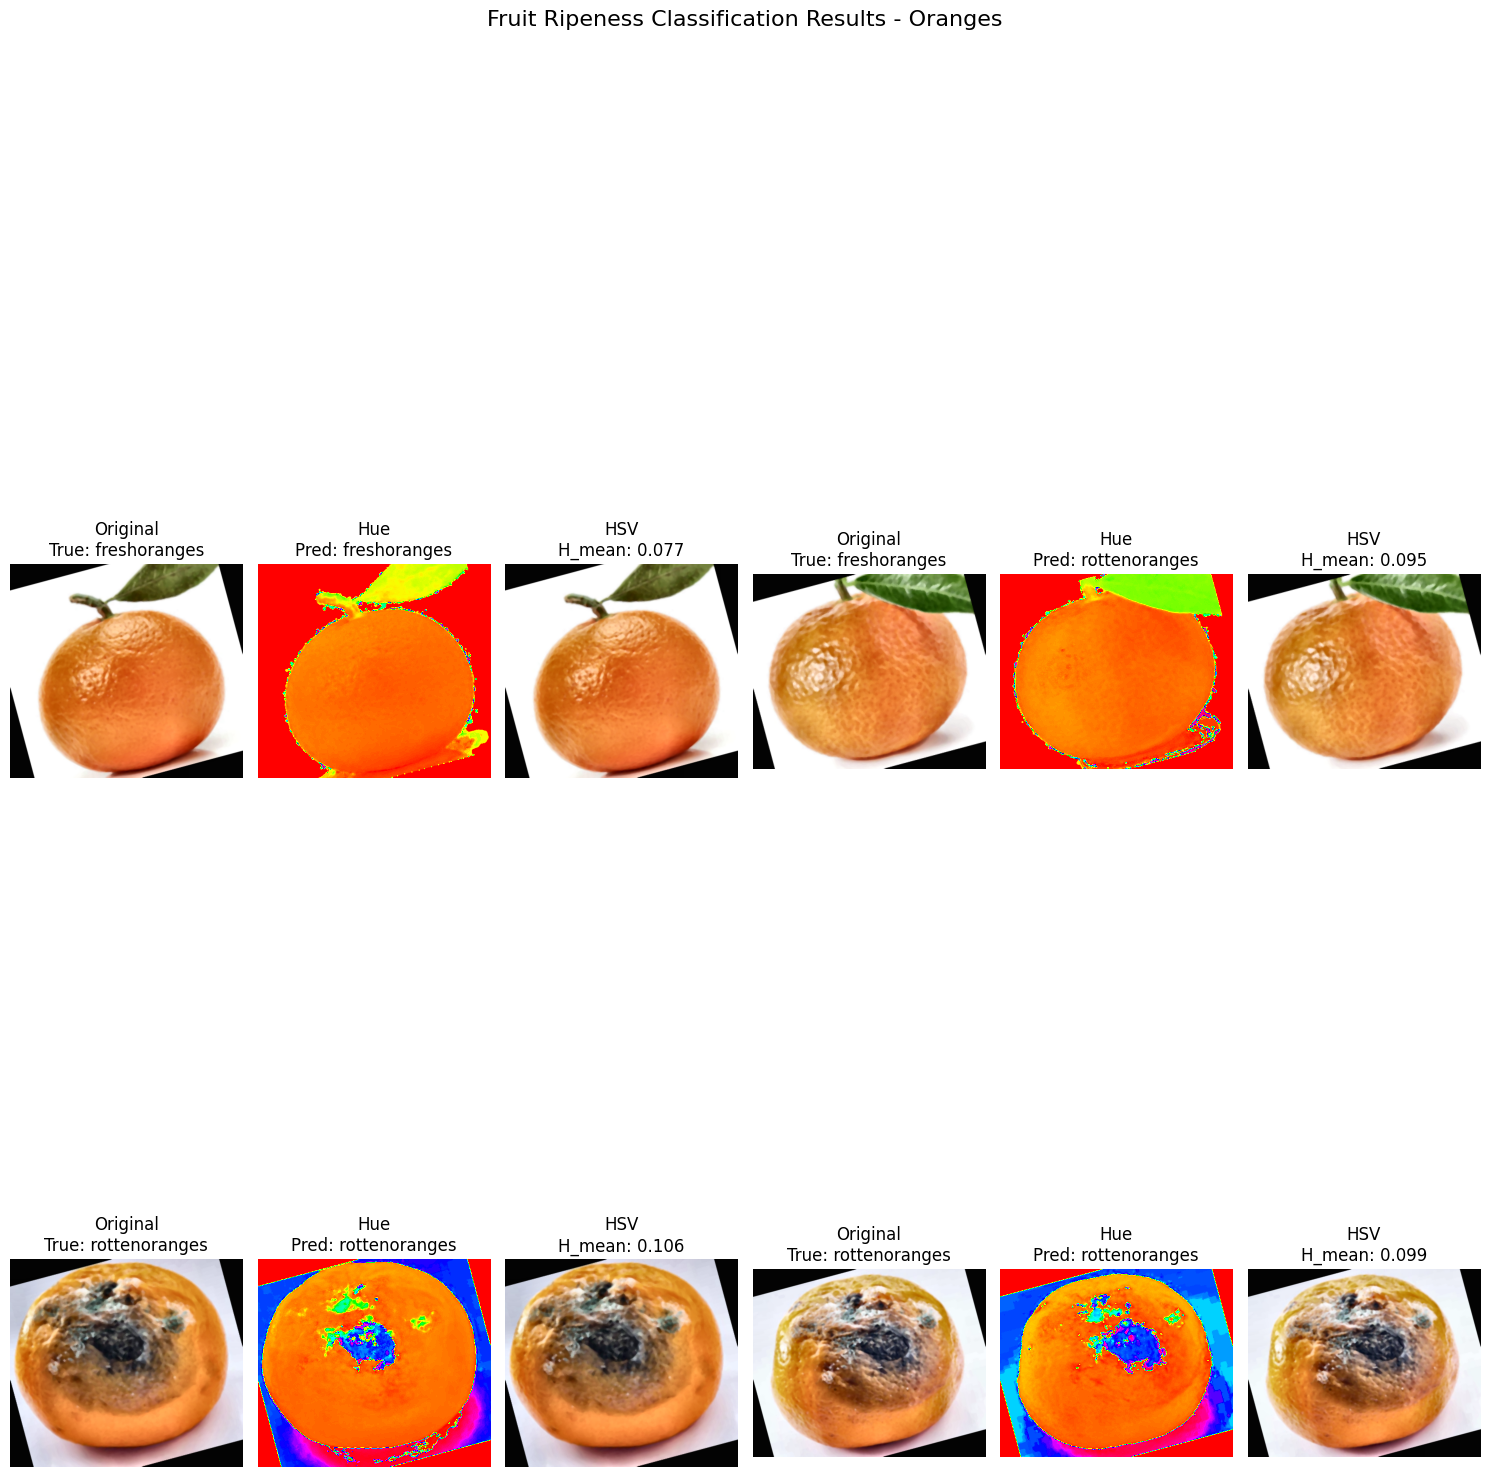

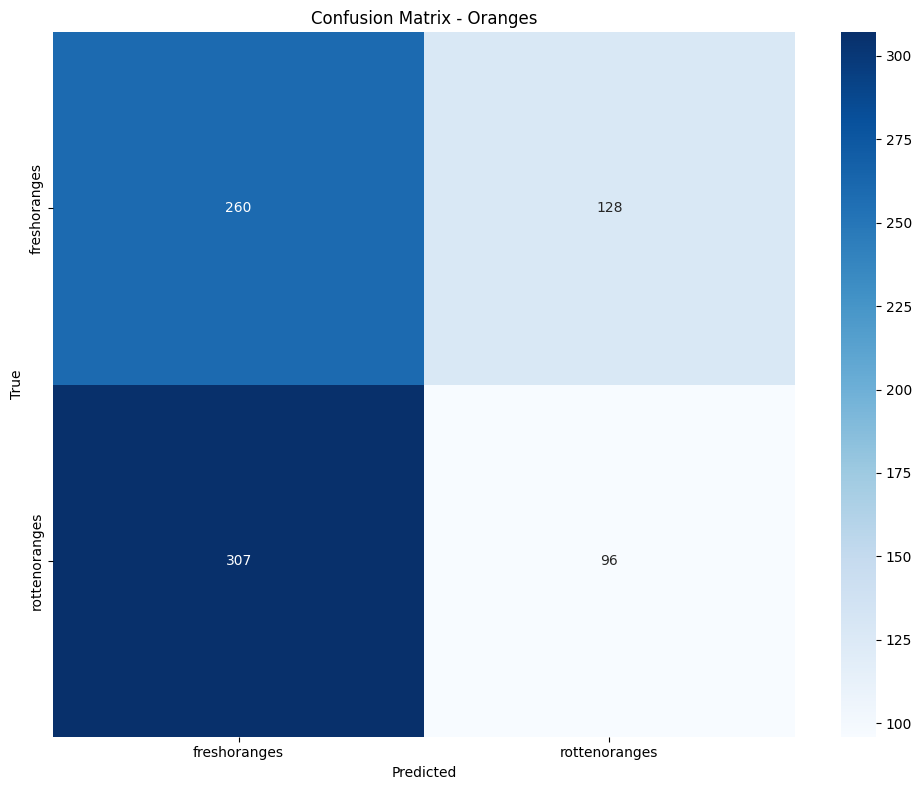

Oranges classification accuracy: 0.4501

=== Final Accuracies ===
Apples: 0.8233
Banana: 0.8496
Oranges: 0.4501


In [21]:
# =======================
# MAIN PROGRAM START HERE
# =======================

if __name__ == "__main__":
    # Pakai path absolut kamu
    base_dir = r"datasets"
    train_dir = os.path.join(base_dir, "train")
    test_dir = os.path.join(base_dir, "test")

    fruit_types = ['apples', 'banana', 'oranges']
    final_results = {}

    for fruit in fruit_types:
        print(f"\n==== Processing {fruit.upper()} ====\n")
        categories = [f"fresh{fruit}", f"rotten{fruit}"]
        classifier = FruitRipenessClassifier(train_dir, test_dir)
        classifier.categories = categories
        accuracy = classifier.run(fruit_name=fruit)
        final_results[fruit] = accuracy
        print(f"{fruit.capitalize()} classification accuracy: {accuracy:.4f}")

    print("\n=== Final Accuracies ===")
    for fruit, acc in final_results.items():
        print(f"{fruit.capitalize()}: {acc:.4f}")


# **Evaluasi** 

**Apel**

freshapples : hue range = 0.000 – 0.629

rottenapples : hue range = 0.000 – 0.272

Nilai ini menunjukkan bahwa apel segar memiliki keragaman warna lebih tinggi, sedangkan apel busuk cenderung berada pada spektrum hue yang lebih rendah dan sempit.

- Prediksi berhasil dengan nilai H_mean = 0.327 yang berada dalam rentang freshapples.
- Ada kesalahan prediksi: apel segar diprediksi sebagai rottenapples, karena nilai hue-nya (H_mean = 0.057) sangat rendah dan mendekati distribusi apel busuk.
- Gambar apel busuk menunjukkan bentuk dan tekstur membusuk yang mencerminkan distribusi hue lebih sempit dan lebih merah kekuningan (dengan H_mean serendah 0.036 dan 0.162), dan berhasil diklasifikasikan dengan benar oleh model.


Akurasi keseluruhan mencapai 82.33% (atau 0.8233)
Hasil ini menunjukkan bahwa model cukup efektif dalam membedakan buah segar dan busuk hanya berdasarkan informasi warna (hue).

**Pisang**

freshbanana : hue range = 0.094 – 0.180

rottenbanana : hue range = 0.000 – 0.249

- Pisang segar memiliki warna dominan pada rentang kuning ke hijau muda (nilai hue menengah).
- Pisang busuk memiliki hue yang lebih bervariasi karena warna kulit berubah dari kuning → coklat tua → hampir hitam, sehingga mencakup rentang hue lebih luas.
- Model mampu mengenali pisang segar dari dominasi warna kuning.
- Pisang busuk ditandai dengan dominasi warna coklat/hitam yang menghasilkan hue rendah.
- Area dominan dalam channel hue diperkuat dengan segmentasi berdasarkan saturasi (S) dan value (V) untuk fokus hanya pada bagian buah, bukan latar belakang.

Model mencapai akurasi sebesar 84.96% (0.8496) pada dataset pisang. Tingginya akurasi ini menunjukkan bahwa perbedaan warna dominan (hue) sangat efektif dalam membedakan kondisi pisang.



**Jeruk**

freshoranges : 0.011 – 0.169
rottenoranges : 0.000 – 0.176

Rentang hue untuk kedua kategori sangat tumpang tindih, yang menunjukkan bahwa warna dominan pada jeruk segar dan busuk memiliki kemiripan tinggi secara visual, terutama pada bagian kulit yang masih terlihat oranye walaupun sudah membusuk.

- Beberapa jeruk segar berhasil diprediksi dengan benar, seperti pada gambar dengan H_mean = 0.077.
- Namun ada kasus jeruk segar yang diprediksi sebagai busuk, karena memiliki warna yang agak pudar (H_mean = 0.095) dan mendekati batas atas kategori rottenoranges.
- jeruk busuk dengan kerusakan yang tampak jelas (bercak hitam dan tekstur rusak) tetap diklasifikasikan benar sebagai rottenoranges meskipun H_mean-nya berada dalam rentang yang sangat mirip dengan jeruk segar (H_mean = 0.106 dan 0.099).

Akurasi model hanya mencapai 45.01% (0.4501) pada data pengujian jeruk. Hal ini menandakan bahwa model kesulitan membedakan kondisi jeruk berdasarkan hue saja, disebabkan oleh kemiripan warna antara jeruk segar dan jeruk busuk yang belum sepenuhnya berubah secara warna, Ketidakseimbangan dan kekurangan data pada kategori jeruk menjadi salah satu penyebab utama menurunnya akurasi klasifikasi.

# **Kesimpulan**

Penelitian ini mengembangkan dan mengimplementasikan sistem klasifikasi tingkat kematangan buah menggunakan metode ekstraksi warna berbasis ruang warna HSV, dengan fokus pada komponen Hue (H) sebagai fitur utama.

Hasil klasifikasi menunjukkan bahwa:

🍎 Apel berhasil diklasifikasikan dengan akurasi 82.33%.

   Perbedaan hue antara apel segar dan busuk cukup jelas, sehingga model dapat membedakan keduanya secara efektif berdasarkan distribusi warna dominan.

🍌 Pisang juga menghasilkan akurasi tinggi sebesar 84.96%.

   Warna kulit pisang yang berubah drastis saat membusuk (dari kuning cerah menjadi coklat tua) menjadikan hue sebagai indikator yang kuat dalam proses klasifikasi.

🍊 Jeruk mengalami penurunan performa dengan akurasi hanya 45.01%.

   Hal ini disebabkan oleh dua faktor utama:

      - Rentang hue antara jeruk segar dan busuk sangat tumpang tindih, karena warna kulit jeruk tidak mengalami perubahan signifikan secara visual meskipun membusuk.
      - Jumlah data pelatihan pada kategori jeruk relatif lebih sedikit, yang menghambat kemampuan model dalam melakukan generalisasi.